**Problem Statement**

We have to perform cohort and RFM analysis to understand the value derived from different customer segments. Further, we will divide customers in different clusters based on the analysis by using K-means algorithm.


**Dataset Description**

This is a transnational data set which contains all the transactions that occurred between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique and all-occasion gifts.

**Variables Description**
- InvoiceNo Invoice number. Nominal, a six digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation

- StockCode Product (item) code. Nominal, a five digit integral number uniquely assigned to each distinct product

- Description Product (item) name. Nominal

- Quantity The quantities of each product (item) per transaction. Numeric

- InvoiceDate Invoice Date and time. Numeric, the day and time when each transaction was generated

- UnitPrice Unit price. Numeric, product price per unit in sterling

- CustomerID Customer number. Nominal, a six digit integral number uniquely assigned to each customer

- Country Country name. Nominal, the name of the country where each customer resides


# 1.data preperation


## 1.1 importing req lib

In [ ]:
# import library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

#For Data  Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For Machine Learning Algorithm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df=pd.read_csv("/content/drive/My Drive/summer internship/ecommerce.csv",encoding="ISO-8859-1")

The DataFrame contains the information about customer's purchases across United Kingdom. There are nearly about 4000 customers and their purchases during the period of one year (from 2010-12-01 to 2011-12-09).

In [ ]:
# converting invoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) 


## 1.2 data overview statistics

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## 1.3Handling missing values

In [ ]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Text(0.5, 1.0, 'Ratio of missing values per columns')

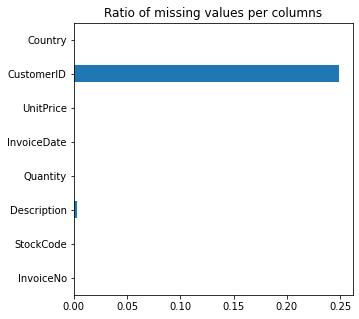

In [ ]:
plt.figure(figsize=(5, 5))
df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

from the above bar graph,we can clearly see that there are missing values in customerid and description.So we have to drop them

In [ ]:
df= df.dropna(subset=['CustomerID'])


In [ ]:
data_info=pd.DataFrame(df.dtypes)
data_info['Null_values']=df.isnull().sum()
data_info['Percentage']=df.isnull().sum()/len(df)
data_info.rename(columns={0: 'Data Type', 'Null_values': '# of Null Values','Percentage': '%age of Null Values'},inplace=True)

print('Dimension of df now: ', df.shape)
print('\n \nData Type and Null population Information:')
display(data_info)

Dimension of df now:  (406829, 8)

 
Data Type and Null population Information:


,Data Type,# of Null Values,%age of Null Values
InvoiceNo,object,0,0.0
StockCode,object,0,0.0
Description,object,0,0.0
Quantity,int64,0,0.0
InvoiceDate,datetime64[ns],0,0.0
UnitPrice,float64,0,0.0
CustomerID,float64,0,0.0
Country,object,0,0.0


In [ ]:
df.isnull().sum().sum()

0

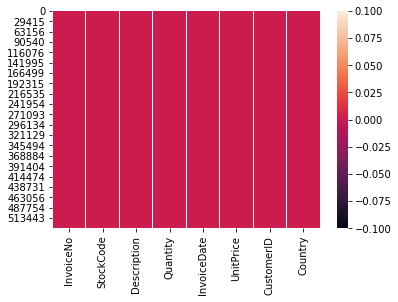

In [ ]:
sns.heatmap(df.isnull())

**from the above heatmap we can say that there are no missing values**

## 1.4handling duplicate values

In [ ]:
df.duplicated().sum()

5225

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.duplicated().sum()

0

# 2Data Exploration

## 2.1data check

In [ ]:
# Checking if the data is at a summarized level
level_check=df.groupby(['InvoiceNo','StockCode','Description','InvoiceDate','Quantity','UnitPrice'])['CustomerID'].count().reset_index()
level_check[level_check['CustomerID'] > 1]


,InvoiceNo,StockCode,Description,InvoiceDate,Quantity,UnitPrice,CustomerID


**There is no ouput. This confirms that the data is at a summarized level. And we have also checked if one invoice corresponds to one customers**


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


The Quantity column has a negative value in it. But logically it should not, because the customer can not buy a negative amount of merchant. It is impossible. But maybe it is a way that store register such sales as installment plan. But maybe I am wrong.

Also the UnitPrice column have zero price rows. It means that we sell for free.

In [ ]:
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df.describe() 

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [ ]:
df.shape

(392692, 8)

#3Customer segmentation

## 3.1Cohort analysis

**For cohort analysis, there are a few labels that we have to create:**

- Invoice period: A string representation of the year and month of a single transaction/invoice.
- Cohort group: A string representation of the the year and month of a customer’s first purchase. This label is common across all invoices for a particular customer.
- Cohort period / Cohort Index: A integer representation a customer’s stage in its “lifetime”. The number represents the number of months passed since the first purchase.


In [ ]:
def get_month(x) : return dt.datetime(x.year,x.month,1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
grouping = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouping.transform('min')
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-01,2011-08-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01,2011-08-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12-01,2011-08-01


In [ ]:
def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day 

invoice_year,invoice_month,_ = get_month_int(df,'InvoiceMonth')
cohort_year,cohort_month,_ = get_month_int(df,'CohortMonth')

year_diff = invoice_year - cohort_year 
month_diff = invoice_month - cohort_month 

df['CohortIndex'] = year_diff * 12 + month_diff + 1 

In [ ]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392692 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     392692 non-null  object        
 1   StockCode     392692 non-null  object        
 2   Description   392692 non-null  object        
 3   Quantity      392692 non-null  int64         
 4   InvoiceDate   392692 non-null  datetime64[ns]
 5   UnitPrice     392692 non-null  float64       
 6   CustomerID    392692 non-null  float64       
 7   Country       392692 non-null  object        
 8   InvoiceMonth  392692 non-null  datetime64[ns]
 9   CohortMonth   392692 non-null  datetime64[ns]
 10  CohortIndex   392692 non-null  int64         
dtypes: datetime64[ns](3), float64(2), int64(2), object(4)
memory usage: 36.0+ MB


## 3.2Calculating retention dates

**Customer retention is a very useful metric to understand how many of the all customers are still active.Retention gives you the percentage of active customers compared to the total number of customers.**



In [ ]:
#Counting montly active customer from each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')
cohort_counts

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Retention table
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 to ensure the divide along the row axis 
retention.round(3) * 100 #to show the number as percentage 

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


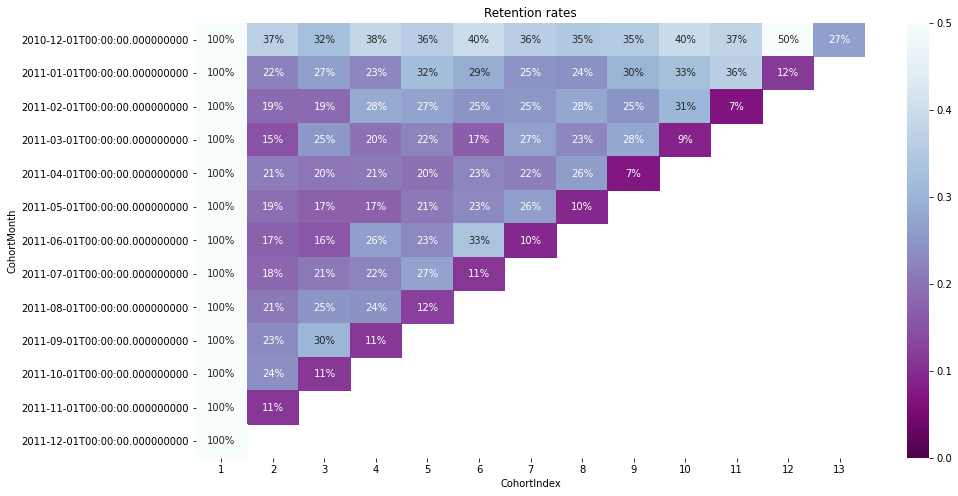

In [ ]:
#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Retention rates')
sns.heatmap(data=retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="BuPu_r")
plt.show()


Customer retention is a very useful metric to understand how many of the all customers are still active.Retention gives you the percentage of active customers compared to the total number of customers.

## 3.3Average quantity for each cohort

Another useful metric for behavioural analytics and customer analytics is to calculate tha average quantity of products that customers buy in the E-Commerce store and visualise it in similar cohort table like above for the retention analytics.

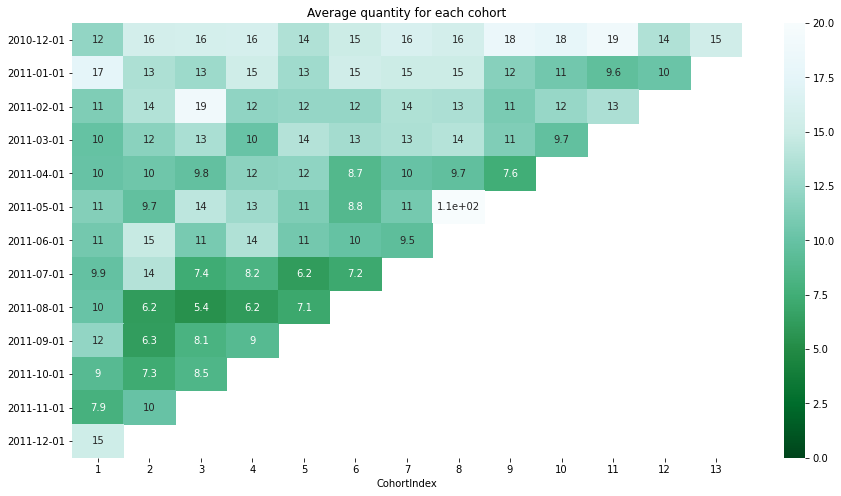

In [ ]:
#Average quantity for each cohort
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Quantity')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

#Build the heatmap
plt.figure(figsize=(15, 8))
plt.title('Average quantity for each cohort')
sns.heatmap(data=average_quantity,annot = True,vmin = 0.0,vmax =20,cmap="BuGn_r")
plt.show()

## 3.4Creating RFM fields

**RFM can be done in many ways but we are using
 percentile-based grouping.**

*Process of calculating percentiles:*

1. Sort customers based on that metric
2.Break customers into a pre-defined number of groups of equal size
3. Assign a label to each group

In [ ]:
#New Total Sum Column  
df['TotalSum'] = df['UnitPrice']* df['Quantity']

#Data preparation steps
print('Min Invoice Date:',df.InvoiceDate.dt.date.min(),'max Invoice Date:',
       df.InvoiceDate.dt.date.max())

df.head(3)

Min Invoice Date: 2010-12-01 max Invoice Date: 2011-12-09


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,1,22.00


In [ ]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
snapshot_date
#The last day of purchase in total is 09 DEC, 2011. To calculate the day periods, 
#let's set one day after the last one,or 
#10 DEC as a snapshot_date. We will cound the diff days with snapshot_date.

Timestamp('2011-12-10 12:50:00')

In [ ]:
# Calculate RFM metrics
rfm = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x : (snapshot_date - x.max()).days,
                                      'InvoiceNo':'count','TotalSum': 'sum'})
#Function Lambdea: it gives the number of days between hypothetical today and the last transaction

#Rename columns
rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalSum':'MonetaryValue'}
           ,inplace= True)

#Final RFM values
rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


let's create three separate groups based on Recency, Frequency and Monetary Value of customers.

In [ ]:
#Building RFM segments
r_labels =range(4,0,-1)
f_labels=range(1,5)
m_labels=range(1,5)
r_quartiles = pd.qcut(rfm['Recency'], q=4, labels = r_labels)
f_quartiles = pd.qcut(rfm['Frequency'],q=4, labels = f_labels)
m_quartiles = pd.qcut(rfm['MonetaryValue'],q=4,labels = m_labels)
rfm = rfm.assign(R=r_quartiles,F=f_quartiles,M=m_quartiles)

# Build RFM Segment and RFM Score
def add_rfm(x) : return str(x['R']) + str(x['F']) + str(x['M'])
rfm['RFM_Segment'] = rfm.apply(add_rfm,axis=1 )
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)

rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6.0
12347.0,2,182,4310.00,4,4,4,444,12.0
12348.0,75,31,1797.24,2,2,4,224,8.0
12349.0,19,73,1757.55,3,3,4,334,10.0
12350.0,310,17,334.40,1,1,2,112,4.0


 RFM score is a simply sum of the Recency, Frequency and Monetary Values and this sum is a result of integer values like 10, 9, 8 and etc. This score will indicate the value of RFM score that will allow us to make decisions on a business product or on our customers. This is very important metric due to future decision-making process concerning the users or customers.

## 3.5Analyzing RFM segmets

In [ ]:
rfm.groupby(['RFM_Segment']).size().sort_values(ascending=False)[:5]

RFM_Segment
444    450
111    381
344    217
122    206
211    179
dtype: int64

## 3.6filtering on RFM segments

In [ ]:
#Select bottom RFM segment "111" and view top 5 rows
rfm[rfm['RFM_Segment']=='111'].head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12353.0,204,4,89.00,1,1,1,111,3.0
12361.0,287,10,189.90,1,1,1,111,3.0
12401.0,303,5,84.30,1,1,1,111,3.0
12402.0,323,11,225.60,1,1,1,111,3.0
12441.0,367,11,173.55,1,1,1,111,3.0


###3.6.1Summary metrics per RFM Score

In [ ]:
rfm.groupby('RFM_Score').agg({'Recency': 'mean','Frequency': 'mean',
                             'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3.0         260.7       8.2         157.4   381
4.0         177.2      13.6         240.0   388
5.0         152.9      21.2         366.6   518
6.0          95.9      27.9         820.8   457
7.0          79.6      38.0         758.1   463
8.0          64.1      56.0         987.3   454
9.0          45.9      78.7        1795.1   414
10.0         32.4     110.5        2056.4   426
11.0         21.3     186.9        4062.0   387
12.0          7.2     367.8        9285.9   450

###3.6.2Use RFM score to group customers into Gold, Silver and Bronze segments:

In [ ]:
def segments(df):
    if df['RFM_Score'] > 9 :
        return 'Gold'
    elif (df['RFM_Score'] > 5) and (df['RFM_Score'] <= 9 ):
        return 'Sliver'
    else:  
        return 'Bronze'

rfm['General_Segment'] = rfm.apply(segments,axis=1)

rfm.groupby('General_Segment').agg({'Recency':'mean','Frequency':'mean',
                                    'MonetaryValue':['mean','count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            192.2      15.1         266.5  1287
Gold               20.1     225.6        5246.8  1263
Sliver             72.0      49.4        1072.4  1788

# 4.Data preprocessing for k-means cluster

There are some critical assumptions with K-Means algorithm before building it:

1. All variable must have symmetrical distribution and should not be skewed.
2. All variables should have the same or almost the same average values.
3. All variables should have the same level of variance.

In [ ]:
rfm_rfm = rfm[['Recency','Frequency','MonetaryValue']]
print(rfm_rfm.describe())

           Recency    Frequency  MonetaryValue
count  4338.000000  4338.000000    4338.000000
mean     92.536422    90.523744    2048.688081
std     100.014169   225.506968    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000    17.000000     306.482500
50%      51.000000    41.000000     668.570000
75%     142.000000    98.000000    1660.597500
max     374.000000  7676.000000  280206.020000


**From this table, we find this Problem: Mean and Variance are not Equal**

*Solution: Scaling variables by using a scaler from scikit-learn library*

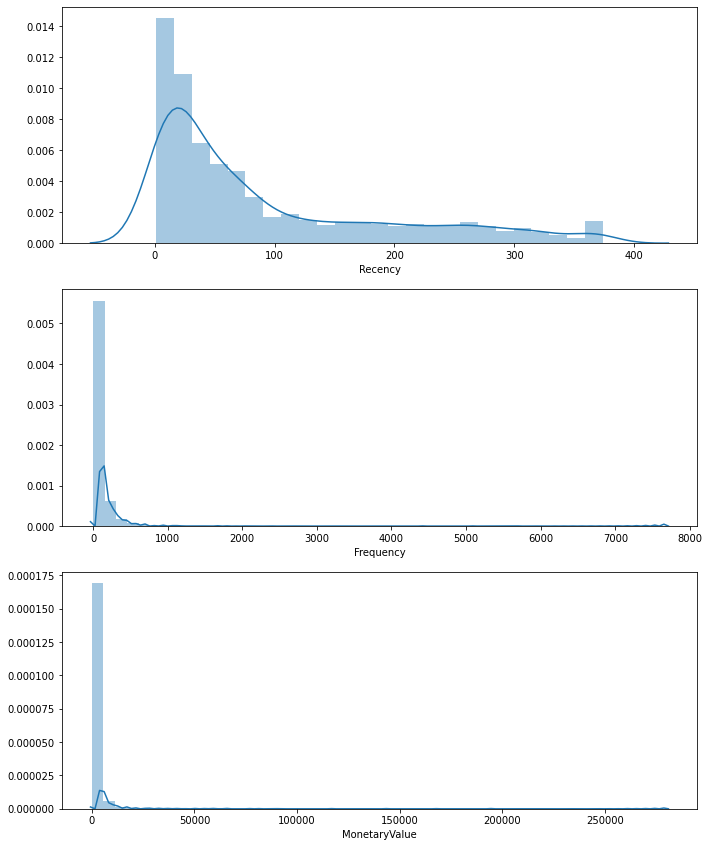

In [ ]:
# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm.MonetaryValue, label = 'Monetary Value')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

As can be seen from the visual represenation of the RFM data. All metrics are right skewed and we need to get rid from skewness by applying either Log Transformation or Z-Transformation. I prefer to do the log transformation in such case because the data has no negative values and ideally prepared for this kind of method.

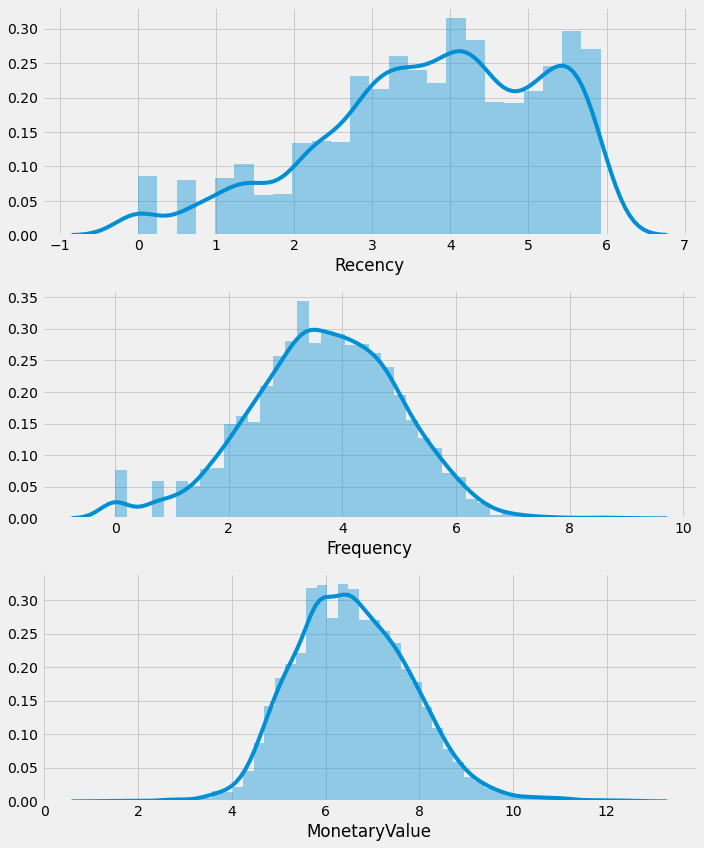

In [ ]:
#Unskew the data with log transformation
rfm_log = rfm[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis = 1).round(3)
#or rfm_log = np.log(rfm_rfm)


# plot the distribution of RFM values
f,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); sns.distplot(rfm_log.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_log.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_log.MonetaryValue, label = 'Monetary Value')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

We can see that recency_log transformed metric is still do not have a good normal shape of distribution. 

so,i'll use standardscalar on log transformed data

#5.Implementation of K-Means clustering

## 5.1Data preprocessing

In [ ]:
#Normalize the variables with StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)
#Store it separately for clustering
rfm_normalized= scaler.transform(rfm_log)

## 5.2Choosing no.of clusters

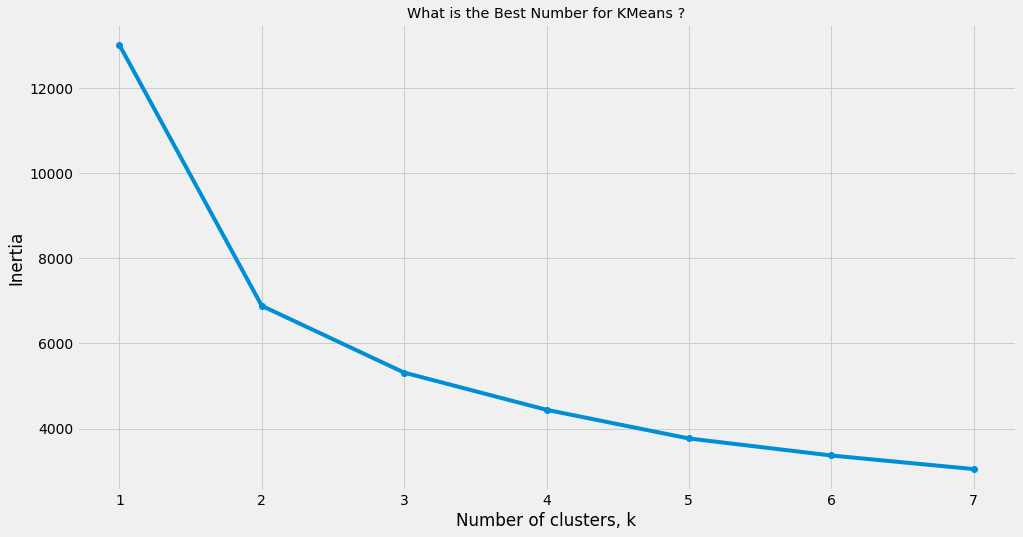

In [ ]:
from sklearn.cluster import KMeans

#First : Get the Best KMeans 
ks = range(1,8)
inertias=[]
for k in ks :
    # Create a KMeans clusters
    kc = KMeans(n_clusters=k,random_state=1)
    kc.fit(rfm_normalized)
    inertias.append(kc.inertia_)

# Plot ks vs inertias
f, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.style.use('ggplot')
plt.title('What is the Best Number for KMeans ?')
plt.show()

**here,we are using no.of clusters=3**
because The scope of the Elbow Method is to choose the number of cluster where the graph breaks. Ususally it is number 3 so 3 clusters must be in the algorithm. 

In [ ]:
# clustering
kc = KMeans(n_clusters= 3, random_state=1)
kc.fit(rfm_normalized)

#Create a cluster label column in the original DataFrame
cluster_labels = kc.labels_

#Calculate average RFM values and size for each cluster:
rfm_rfm_k3 = rfm_rfm.assign(K_Cluster = cluster_labels)

#Calculate average RFM values and sizes for each cluster:
rfm_rfm_k3.groupby('K_Cluster').agg({'Recency': 'mean','Frequency': 'mean',
                                         'MonetaryValue': ['mean', 'count'],}).round(0)

Recency Frequency MonetaryValue      
             mean      mean          mean count
K_Cluster                                      
0            13.0     260.0        6554.0   957
1            69.0      65.0        1167.0  1858
2           171.0      15.0         293.0  1523

*Snake plots to understand and compare segments*

- Market research technique to compare different segments
- Visual representation of each segment's attributes
- Need to first normalize data (center & scale)
Plot each cluster's average normalized values of each attribute

In [ ]:
rfm_normalized = pd.DataFrame(rfm_normalized,index=rfm_rfm.index,columns=rfm_rfm.columns)
rfm_normalized['K_Cluster'] = kc.labels_
rfm_normalized['General_Segment'] = rfm['General_Segment']
rfm_normalized.reset_index(inplace = True)

#Melt the data into a long format so RFM values and metric names are stored in 1 column each
rfm_melt = pd.melt(rfm_normalized,id_vars=['CustomerID','General_Segment','K_Cluster'],value_vars=['Recency', 'Frequency', 'MonetaryValue'],
var_name='Metric',value_name='Value')
rfm_melt.head()

,CustomerID,General_Segment,K_Cluster,Metric,Value
0,12346.0,Sliver,1,Recency,1.409982
1,12347.0,Gold,0,Recency,-2.146578
2,12348.0,Sliver,1,Recency,0.383648
3,12349.0,Gold,1,Recency,-0.574961
4,12350.0,Bronze,2,Recency,1.375072


In [ ]:
# The further a ratio is from 0, the more important that attribute is for a segment relative to the total population
cluster_avg = rfm_rfm_k3.groupby(['K_Cluster']).mean()
population_avg = rfm_rfm.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
K_Cluster,,,
0,-0.86,1.87,2.20
1,-0.25,-0.28,-0.43
2,0.85,-0.84,-0.86


In [ ]:
# the mean value in total 
total_avg = rfm.iloc[:, 0:3].mean()
# calculate the proportional gap with total mean
cluster_avg = rfm.groupby('General_Segment').mean().iloc[:, 0:3]
prop_rfm = cluster_avg/total_avg - 1
prop_rfm.round(2)

,Recency,Frequency,MonetaryValue
General_Segment,,,
Bronze,1.08,-0.83,-0.87
Gold,-0.78,1.49,1.56
Sliver,-0.22,-0.45,-0.48


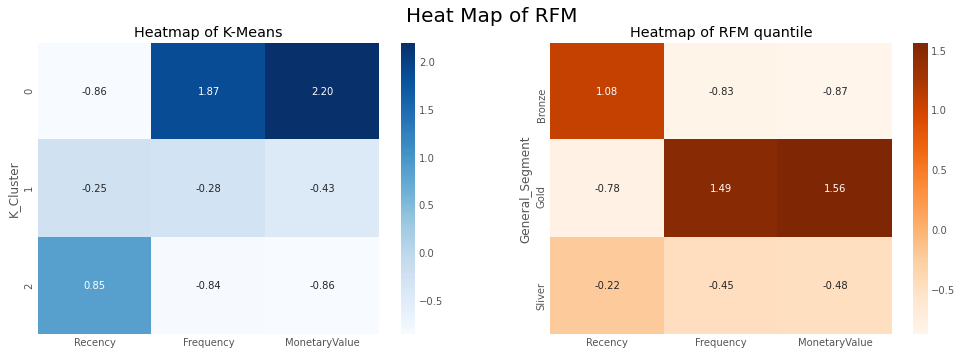

In [ ]:
# heatmap with RFM
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Blues',ax=ax1)
ax1.set(title = "Heatmap of K-Means")


sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True,ax=ax2)
ax2.set(title = "Heatmap of RFM quantile")

plt.suptitle("Heat Map of RFM",fontsize=20) #make title fontsize subtitle 

plt.show()


# 6.Tenure

In [ ]:
tenure_list = []
for i in list(rfm_rfm.index):
    tenure_list.append((df.InvoiceDate.max() - df[(df.CustomerID == i)]['InvoiceDate'].min()).days + 1)

In [ ]:
data_rfmt = rfm_rfm.assign(Tenure = tenure_list)
data_rfmt.min()

Recency          1.00
Frequency        1.00
MonetaryValue    3.75
Tenure           1.00
dtype: float64

In [ ]:
data_rfmt_log = np.log(data_rfmt)
scaler = StandardScaler()
scaler.fit(data_rfmt_log)
data_rfmt_normalized = scaler.transform(data_rfmt_log)

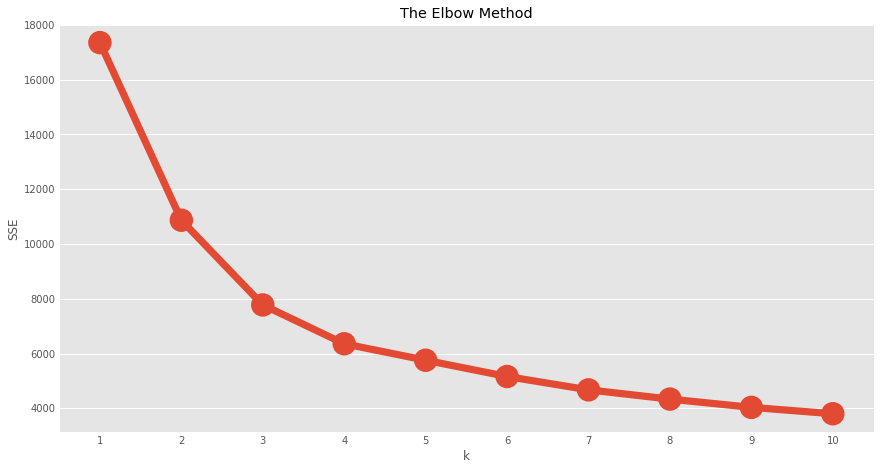

In [ ]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(data_rfmt_normalized)
    sse[k] = kmeans.inertia_ 

plt.figure(figsize = (13,7))
plt.title('The Elbow Method'); plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=1) 
kmeans.fit(data_rfmt_normalized)
cluster_labels = kmeans.labels_

In [ ]:
data_rfmt_k3 = data_rfmt.assign(Cluster=cluster_labels)
grouped = data_rfmt_k3.groupby(['Cluster'])
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'Tenure': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue Tenure      
           mean      mean          mean   mean count
Cluster                                             
0         183.2      26.4         554.5  255.5  1714
1          36.0      33.1         497.8   52.6   955
2          31.8     189.2        4470.6  287.9  1669

 **Conclusion:**

We talked about how to get RFM values from customer purchase data, and we made two kinds of segmentation with RFM quantiles and K-Means clustering methods.
By performing Cohort analysis you can get following answers to following questions:

- How much effective was a marketing campaign held in a particular time period.
- Should I focus more on retention rather than acquiring new customers?
-  Is there a seasoanlity pattern in Customer behahiour?
- along with varios perfromance measures/metrics for your organisation.